# Cough Detection (5s) - Clean Training Pipeline

This notebook follows a simple flow similar to the old 9s notebook:
1. Import and label dataset from metadata.
2. Truncate each clip to 5 seconds.
3. Extract MFCC features.
4. Train the model.
5. Evaluate and export (`.h5` and int8 `.tflite`).

Noise robustness is added in training through waveform augmentation.


In [61]:
# Cell 1: Imports and GPU runtime setup

import os
# GPU-stable setup (must run before TensorFlow starts using GPU).
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

import json
import random
from pathlib import Path

import numpy as np
import pandas as pd
import librosa
from tqdm import tqdm

import tensorflow as tf
import keras
from keras import layers
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, roc_auc_score


In [62]:
# Cell 2: Global configuration and hyperparameters

# =====================
# Configuration
# =====================
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

PUBLIC_DATASET_CANDIDATES = [Path('../public_dataset'), Path('public_dataset')]
ESP32_NOISE_CANDIDATES = [Path('./esp32_dataset/non_cough'), Path('model/esp32_dataset/non_cough')]


def first_existing(paths):
    for p in paths:
        if p.exists():
            return p
    return paths[0]


PUBLIC_DATASET_DIR = first_existing(PUBLIC_DATASET_CANDIDATES)
ESP32_NOISE_DIR = first_existing(ESP32_NOISE_CANDIDATES)

OUTPUT_PREFIX = 'cough_cnn_5s_base'

# Strong labels from public metadata
POS_THRESHOLD = 0.80  # cough_detected >= 0.80 -> cough
NEG_THRESHOLD = 0.20  # cough_detected <= 0.20 -> non-cough

# Audio + MFCC
SR = 16000
DURATION = 5.0
TARGET_SAMPLES = int(SR * DURATION)

N_MFCC = 40
N_MELS = 128
N_FFT = 1024
HOP_LENGTH = 512
EXPECTED_FRAMES = 1 + int(np.floor((TARGET_SAMPLES - N_FFT) / float(HOP_LENGTH)))

# Split
TEST_SIZE = 0.15
VAL_SIZE_FROM_TRAIN = 0.1765  # gives ~15% total val when test is 15%

# Training
BATCH_SIZE = 8
EPOCHS = 55
LEARNING_RATE = 2e-4

# Optional caps for quick experiments (set None for full dataset)
MAX_TRAIN_PER_CLASS = None
MAX_VAL_PER_CLASS = None
MAX_TEST_PER_CLASS = None

# Data augmentation (training only)
AUG_PER_SAMPLE = 2
USE_BACKGROUND_NOISE_MIX = True
SPECAUGMENT_PROB = 0.35
NON_COUGH_WEIGHT_BOOST = 1.15

print('Target clip:', DURATION, 'seconds')
print('Expected MFCC shape:', (EXPECTED_FRAMES, N_MFCC))
print('USE_BACKGROUND_NOISE_MIX:', USE_BACKGROUND_NOISE_MIX)
print('AUG_PER_SAMPLE:', AUG_PER_SAMPLE, 'SPECAUGMENT_PROB:', SPECAUGMENT_PROB)


Target clip: 5.0 seconds
Expected MFCC shape: (155, 40)
USE_BACKGROUND_NOISE_MIX: True
AUG_PER_SAMPLE: 2 SPECAUGMENT_PROB: 0.35


In [63]:
# Cell 3: Build metadata table from public dataset files

# =====================
# Step 1: Build metadata table
# =====================

def build_dataframe(dataset_dir, pos_threshold=0.8, neg_threshold=0.2):
    files = []
    cough_scores = []
    labels = []

    for wav_path in sorted(dataset_dir.glob('*.wav')):
        json_path = wav_path.with_suffix('.json')
        if not json_path.exists():
            continue

        try:
            meta = json.loads(json_path.read_text(encoding='utf-8'))
            score = float(meta.get('cough_detected'))
        except Exception:
            continue

        if score >= pos_threshold:
            label = 1
        elif score <= neg_threshold:
            label = 0
        else:
            continue

        files.append(str(wav_path.resolve()))
        cough_scores.append(score)
        labels.append(label)

    df = pd.DataFrame({
        'wav_path': files,
        'cough_score': cough_scores,
        'label': labels,
    })
    return df


df = build_dataframe(PUBLIC_DATASET_DIR, POS_THRESHOLD, NEG_THRESHOLD)

print('Total usable samples:', len(df))
print('Class distribution:', df['label'].value_counts().to_dict())
print(df.head(3))


Total usable samples: 17839
Class distribution: {1: 12290, 0: 5549}
                                            wav_path  cough_score  label
0  E:\minor-project\public_dataset\2d22665d-5ca0-...       0.8796      1
1  E:\minor-project\public_dataset\2d25616a-2bee-...       0.0099      0
2  E:\minor-project\public_dataset\2d26833b-337e-...       0.9817      1


In [64]:
# Cell 4: Split metadata into train/validation/test sets

# =====================
# Step 2: Split train/val/test
# =====================

train_df, test_df = train_test_split(
    df,
    test_size=TEST_SIZE,
    random_state=SEED,
    stratify=df['label']
)

train_df, val_df = train_test_split(
    train_df,
    test_size=VAL_SIZE_FROM_TRAIN,
    random_state=SEED,
    stratify=train_df['label']
)


def cap_per_class(split_df, max_per_class, seed=42):
    if max_per_class is None:
        return split_df.reset_index(drop=True)

    return (
        split_df.groupby('label', group_keys=False)
        .apply(lambda g: g.sample(n=min(len(g), int(max_per_class)), random_state=seed))
        .reset_index(drop=True)
    )


train_df = cap_per_class(train_df, MAX_TRAIN_PER_CLASS, SEED)
val_df = cap_per_class(val_df, MAX_VAL_PER_CLASS, SEED)
test_df = cap_per_class(test_df, MAX_TEST_PER_CLASS, SEED)

print('Train:', train_df.shape, train_df['label'].value_counts().to_dict())
print('Val:  ', val_df.shape, val_df['label'].value_counts().to_dict())
print('Test: ', test_df.shape, test_df['label'].value_counts().to_dict())


Train: (12486, 3) {1: 8602, 0: 3884}
Val:   (2677, 3) {1: 1844, 0: 833}
Test:  (2676, 3) {1: 1844, 0: 832}


In [65]:
# Cell 5: Define waveform augmentation and noise helpers

# =====================
# Step 3: Noise pool + augmentation
# =====================

PUBLIC_NOISE_PATHS = train_df.loc[train_df['label'] == 0, 'wav_path'].tolist()
ESP32_NOISE_PATHS = sorted(str(p.resolve()) for p in ESP32_NOISE_DIR.glob('*.wav')) if ESP32_NOISE_DIR.exists() else []

print('Public non-cough noise pool:', len(PUBLIC_NOISE_PATHS))
print('ESP32 non-cough noise pool:', len(ESP32_NOISE_PATHS))


def pad_or_trim(y, target_samples):
    if len(y) < target_samples:
        y = np.pad(y, (0, target_samples - len(y)))
    elif len(y) > target_samples:
        y = y[:target_samples]
    return y.astype(np.float32)


def rms(x):
    return float(np.sqrt(np.mean(np.square(x), dtype=np.float64) + 1e-10))


def mix_at_snr(clean, noise, snr_db):
    clean_rms = max(rms(clean), 1e-4)
    noise_rms = max(rms(noise), 1e-6)
    noise_target_rms = clean_rms / (10.0 ** (snr_db / 20.0))
    return clean + noise * (noise_target_rms / noise_rms)


def sample_noise_clip(target_samples, rng):
    all_noise = []
    if len(PUBLIC_NOISE_PATHS) > 0:
        all_noise.extend(PUBLIC_NOISE_PATHS)
    if len(ESP32_NOISE_PATHS) > 0:
        all_noise.extend(ESP32_NOISE_PATHS)

    if len(all_noise) == 0:
        return np.zeros(target_samples, dtype=np.float32)

    selected = all_noise[rng.integers(0, len(all_noise))]
    y, _ = librosa.load(selected, sr=SR, mono=True)
    y = y.astype(np.float32)

    if len(y) >= target_samples:
        start = int(rng.integers(0, len(y) - target_samples + 1))
        return y[start:start + target_samples]

    reps = int(np.ceil(target_samples / len(y)))
    return np.tile(y, reps)[:target_samples]


def augment_waveform(y, label, rng):
    y = y.astype(np.float32).copy()

    # Global gain + temporal shift
    y *= rng.uniform(0.80, 1.20)

    if rng.random() < 0.70:
        max_shift = int(0.15 * SR)
        shift = int(rng.integers(-max_shift, max_shift + 1))
        y = np.roll(y, shift)

    # Class-aware background mix:
    # non-cough gets stronger noise more often to reduce loudness shortcut.
    if USE_BACKGROUND_NOISE_MIX:
        p_mix = 0.70 if int(label) == 0 else 0.45
        if rng.random() < p_mix:
            n = sample_noise_clip(len(y), rng)
            if int(label) == 0:
                snr_db = rng.uniform(5.0, 18.0)
            else:
                snr_db = rng.uniform(10.0, 24.0)
            y = mix_at_snr(y, n, snr_db)

    # Small hiss
    if rng.random() < 0.20:
        y += rng.uniform(0.0002, 0.0020) * rng.normal(0.0, 1.0, len(y)).astype(np.float32)

    # Random transient spikes (mostly in non-cough)
    if int(label) == 0 and rng.random() < 0.25:
        burst_len = int(rng.integers(int(0.004 * SR), int(0.02 * SR)))
        bstart = int(rng.integers(0, max(1, len(y) - burst_len)))
        y[bstart:bstart + burst_len] += rng.uniform(-0.25, 0.25)

    return np.clip(y, -1.0, 1.0).astype(np.float32)


def spec_augment(mfcc, rng):
    out = mfcc.copy()
    t, f = out.shape

    # One time mask
    t_mask = int(rng.integers(0, max(2, int(0.08 * t))))
    if t_mask > 0:
        t0 = int(rng.integers(0, max(1, t - t_mask + 1)))
        out[t0:t0 + t_mask, :] = 0.0

    # One frequency mask
    f_mask = int(rng.integers(0, max(2, int(0.10 * f))))
    if f_mask > 0:
        f0 = int(rng.integers(0, max(1, f - f_mask + 1)))
        out[:, f0:f0 + f_mask] = 0.0

    return out.astype(np.float32)


Public non-cough noise pool: 3884
ESP32 non-cough noise pool: 327


In [66]:
# Cell 6: Define MFCC feature extraction (5-second clips)

# =====================
# Step 4: MFCC extraction (5s)
# =====================

def extract_mfcc_2d(wav_path=None,
                    y=None,
                    sr=SR,
                    n_mfcc=N_MFCC,
                    n_mels=N_MELS,
                    n_fft=N_FFT,
                    hop_length=HOP_LENGTH,
                    duration=DURATION,
                    max_frames=EXPECTED_FRAMES,
                    normalise=True):
    """
    Extract MFCC as (frames, n_mfcc) from a 5s clip.
    """
    if y is None:
        y, _ = librosa.load(wav_path, sr=sr, mono=True, offset=0.0, duration=duration)

    y = pad_or_trim(y, int(sr * duration))

    mfcc = librosa.feature.mfcc(
        y=y,
        sr=sr,
        n_mfcc=n_mfcc,
        n_mels=n_mels,
        n_fft=n_fft,
        hop_length=hop_length,
        htk=False
    )

    mfcc = mfcc.T.astype(np.float32)

    if max_frames is not None:
        if mfcc.shape[0] < max_frames:
            pad = np.zeros((max_frames - mfcc.shape[0], n_mfcc), dtype=np.float32)
            mfcc = np.vstack([mfcc, pad])
        elif mfcc.shape[0] > max_frames:
            mfcc = mfcc[:max_frames, :]

    if normalise:
        mean = np.mean(mfcc, axis=0, keepdims=True)
        std = np.std(mfcc, axis=0, keepdims=True) + 1e-6
        mfcc = (mfcc - mean) / std

    return mfcc.astype(np.float32)


In [67]:
# Cell 7: Convert audio clips into MFCC feature tensors

def extract_features(df,
                     duration=DURATION,
                     normalise=True,
                     augment=False,
                     aug_per_sample=0,
                     seed=42):
    """
    Build X, y arrays from dataframe.
    If augment=True, generates additional augmented samples per training clip.
    """
    rng = np.random.default_rng(seed)

    n_files = len(df)
    total = n_files * (1 + aug_per_sample if augment else 1)

    X = np.zeros((total, EXPECTED_FRAMES, N_MFCC), dtype=np.float32)
    y = np.zeros((total,), dtype=np.int32)

    idx = 0
    for row in tqdm(df.itertuples(index=False), total=n_files):
        wav_path = row.wav_path
        label = int(row.label)

        base_wave_raw, _ = librosa.load(wav_path, sr=SR, mono=True, offset=0.0, duration=duration)
        base_wave_raw = pad_or_trim(base_wave_raw, TARGET_SAMPLES)

        # original
        base_mfcc = extract_mfcc_2d(y=base_wave_raw, duration=duration, normalise=normalise)
        X[idx] = base_mfcc
        y[idx] = label
        idx += 1

        # augmented copies (training only)
        if augment:
            for _ in range(aug_per_sample):
                aug_wave = augment_waveform(base_wave_raw, label, rng)
                aug_mfcc = extract_mfcc_2d(y=aug_wave, duration=duration, normalise=normalise)

                if rng.random() < SPECAUGMENT_PROB:
                    aug_mfcc = spec_augment(aug_mfcc, rng)

                X[idx] = aug_mfcc.astype(np.float32)
                y[idx] = label
                idx += 1

    return X[:idx], y[:idx]


In [68]:
# Cell 8: Extract train/validation/test features

# Extract features
X_train, y_train = extract_features(
    train_df,
    duration=DURATION,
    normalise=True,
    augment=True,
    aug_per_sample=AUG_PER_SAMPLE,
    seed=SEED
)

X_val, y_val = extract_features(
    val_df,
    duration=DURATION,
    normalise=True,
    augment=False,
    aug_per_sample=0,
    seed=SEED
)

X_test, y_test = extract_features(
    test_df,
    duration=DURATION,
    normalise=True,
    augment=False,
    aug_per_sample=0,
    seed=SEED
)

print('X_train:', X_train.shape, 'y_train:', y_train.shape)
print('X_val:  ', X_val.shape, 'y_val:  ', y_val.shape)
print('X_test: ', X_test.shape, 'y_test: ', y_test.shape)

print('Train class counts:', {0:int(np.sum(y_train==0)), 1:int(np.sum(y_train==1))})
print('Val class counts:  ', {0:int(np.sum(y_val==0)), 1:int(np.sum(y_val==1))})
print('Test class counts: ', {0:int(np.sum(y_test==0)), 1:int(np.sum(y_test==1))})


100%|██████████| 2676/2676 [00:55<00:00, 48.29it/s]


X_train: (37458, 155, 40) y_train: (37458,)
X_val:   (2677, 155, 40) y_val:   (2677,)
X_test:  (2676, 155, 40) y_test:  (2676,)
Train class counts: {0: 11652, 1: 25806}
Val class counts:   {0: 833, 1: 1844}
Test class counts:  {0: 832, 1: 1844}


In [69]:
# Cell 9: Build one-hot labels and class weights

# Prepare labels for categorical training
y_train_onehot = to_categorical(y_train, num_classes=2)
y_val_onehot = to_categorical(y_val, num_classes=2)
y_test_onehot = to_categorical(y_test, num_classes=2)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train
)
class_weight = {0: float(class_weights[0]), 1: float(class_weights[1])}

# Slightly upweight non-cough to reduce false cough alarms.
class_weight[0] = class_weight[0] * NON_COUGH_WEIGHT_BOOST

print('Class weights:', class_weight)


Class weights: {0: 1.8484680741503603, 1: 0.7257614508253895}


In [73]:
# Cell 10: Build, train, and save the CNN model

# =====================
# Step 5: Model + training
# =====================

# Clear any stale graph/state before building a new model.
keras.backend.clear_session()

# Ensure contiguous float32 arrays for stable host->GPU transfer.
X_train = np.ascontiguousarray(X_train, dtype=np.float32)
X_val = np.ascontiguousarray(X_val, dtype=np.float32)
X_test = np.ascontiguousarray(X_test, dtype=np.float32)

y_train_onehot = np.ascontiguousarray(y_train_onehot, dtype=np.float32)
y_val_onehot = np.ascontiguousarray(y_val_onehot, dtype=np.float32)
y_test_onehot = np.ascontiguousarray(y_test_onehot, dtype=np.float32)


def build_tinyml_cnn(input_shape):
    l2 = keras.regularizers.l2(1e-4)

    inputs = tf.keras.Input(shape=input_shape)

    x = layers.Conv1D(32, 3, padding='same', activation='relu', kernel_regularizer=l2)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)

    x = layers.Conv1D(64, 3, padding='same', activation='relu', kernel_regularizer=l2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)

    x = layers.Conv1D(128, 3, padding='same', activation='relu', kernel_regularizer=l2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dropout(0.40)(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer=l2)(x)
    x = layers.Dropout(0.30)(x)

    outputs = layers.Dense(2, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)


class NumpySequence(keras.utils.Sequence):
    def __init__(self, x, y, batch_size=32, sample_weight=None, shuffle=False, seed=42):
        self.x = x
        self.y = y
        self.batch_size = int(batch_size)
        self.sample_weight = sample_weight
        self.shuffle = shuffle
        self.rng = np.random.default_rng(seed)
        self.indices = np.arange(len(self.x))
        if self.shuffle:
            self.rng.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, idx):
        i0 = idx * self.batch_size
        i1 = min((idx + 1) * self.batch_size, len(self.indices))
        batch_idx = self.indices[i0:i1]

        bx = self.x[batch_idx]
        by = self.y[batch_idx]

        if self.sample_weight is None:
            return bx, by

        bw = self.sample_weight[batch_idx]
        return bx, by, bw

    def on_epoch_end(self):
        if self.shuffle:
            self.rng.shuffle(self.indices)


# Convert class_weight into per-sample weights (works with Sequence reliably).
train_sample_weight = np.where(y_train == 0, class_weight[0], class_weight[1]).astype(np.float32)

train_seq = NumpySequence(
    X_train,
    y_train_onehot,
    batch_size=BATCH_SIZE,
    sample_weight=train_sample_weight,
    shuffle=True,
    seed=SEED,
)

val_seq = NumpySequence(
    X_val,
    y_val_onehot,
    batch_size=BATCH_SIZE,
    sample_weight=None,
    shuffle=False,
    seed=SEED,
)

input_shape = X_train.shape[1:]
model = build_tinyml_cnn(input_shape)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.02),
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=f'{OUTPUT_PREFIX}.h5',
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1,
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_auc',
        mode='max',
        factor=0.5,
        patience=4,
        min_lr=5e-6,
        verbose=1,
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_auc',
        mode='max',
        patience=4,
        restore_best_weights=True,
        verbose=1,
    ),
]

history = model.fit(
    train_seq,
    validation_data=val_seq,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1,
)

model = keras.models.load_model(f'{OUTPUT_PREFIX}.h5')


Epoch 1/55
4682/4683 [============================>.] - ETA: 0s - loss: 0.5179 - accuracy: 0.7720 - auc: 0.8554
Epoch 1: val_auc improved from -inf to 0.94869, saving model to cough_cnn_5s_base.h5
4683/4683 [==============================] - 88s 19ms/step - loss: 0.5179 - accuracy: 0.7721 - auc: 0.8554 - val_loss: 0.3387 - val_accuracy: 0.8752 - val_auc: 0.9487 - lr: 2.0000e-04
Epoch 2/55
4683/4683 [==============================] - ETA: 0s - loss: 0.4369 - accuracy: 0.8266 - auc: 0.9059
Epoch 2: val_auc did not improve from 0.94869
4683/4683 [==============================] - 186s 40ms/step - loss: 0.4369 - accuracy: 0.8266 - auc: 0.9059 - val_loss: 0.3564 - val_accuracy: 0.8715 - val_auc: 0.9406 - lr: 2.0000e-04
Epoch 3/55
4683/4683 [==============================] - ETA: 0s - loss: 0.4077 - accuracy: 0.8406 - auc: 0.9200
Epoch 3: val_auc improved from 0.94869 to 0.95729, saving model to cough_cnn_5s_base.h5
4683/4683 [==============================] - 189s 40ms/step - loss: 0.4077 -

In [74]:
val_prob = model.predict(X_val, batch_size=BATCH_SIZE, verbose=0)
val_pred = np.argmax(val_prob, axis=1)
val_acc = float(np.mean(val_pred == y_val))
val_auc = float(roc_auc_score(y_val, val_prob[:, 1]))

test_prob = model.predict(X_test, batch_size=BATCH_SIZE, verbose=0)
test_pred = np.argmax(test_prob, axis=1)
test_acc = float(np.mean(test_pred == y_test))
test_auc = float(roc_auc_score(y_test, test_prob[:, 1]))

print(f'Val accuracy:  {val_acc:.4f}')
print(f'Val AUC:       {val_auc:.4f}')
print(f'Test accuracy: {test_acc:.4f}')

print(f'Test AUC:      {test_auc:.4f}')

print('\nTest classification report:')
print(classification_report(y_test, test_pred, digits=4))
print('Test confusion matrix:\n', confusion_matrix(y_test, test_pred))


Val accuracy:  0.8920
Val AUC:       0.9504
Test accuracy: 0.8954
Test AUC:      0.9498

Test classification report:
              precision    recall  f1-score   support

           0     0.8129    0.8618    0.8366       832
           1     0.9359    0.9105    0.9230      1844

    accuracy                         0.8954      2676
   macro avg     0.8744    0.8861    0.8798      2676
weighted avg     0.8977    0.8954    0.8962      2676

Test confusion matrix:
 [[ 717  115]
 [ 165 1679]]


In [75]:
# Cell 12: Convert trained model to int8 TFLite

# =====================
# Step 7: Convert to int8 TFLite
# =====================

def representative_data_gen():
    n = min(300, len(X_train))
    idx = np.random.choice(len(X_train), size=n, replace=False)
    for i in idx:
        sample = X_train[i:i+1].astype(np.float32)
        yield [sample]


converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

quant_tflite = converter.convert()

model_tflite_path = Path(f'{OUTPUT_PREFIX}_int8.tflite')
model_tflite_path.write_bytes(quant_tflite)
print('Saved TFLite model:', model_tflite_path.resolve())


INFO:tensorflow:Assets written to: C:\Users\Aman\AppData\Local\Temp\tmp9vwgjirl\assets


INFO:tensorflow:Assets written to: C:\Users\Aman\AppData\Local\Temp\tmp9vwgjirl\assets
c:\Users\Aman\anaconda3\envs\tf_gpu_final\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


Saved TFLite model: E:\minor-project\model\cough_cnn_5s_base_int8.tflite


In [76]:
# Cell 13: Print quantization parameters for Arduino integration

# Check quantization parameters (needed for Arduino)
interpreter = tf.lite.Interpreter(model_path=f'{OUTPUT_PREFIX}_int8.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

print('Input shape:', input_details['shape'])
print('Input quantization (scale, zero_point):', input_details['quantization'])
print('Input dtype:', input_details['dtype'])

print('Output shape:', output_details['shape'])
print('Output quantization (scale, zero_point):', output_details['quantization'])
print('Output dtype:', output_details['dtype'])


Input shape: [  1 155  40]
Input quantization (scale, zero_point): (0.09047859907150269, -3)
Input dtype: <class 'numpy.int8'>
Output shape: [1 2]
Output quantization (scale, zero_point): (0.00390625, -128)
Output dtype: <class 'numpy.int8'>


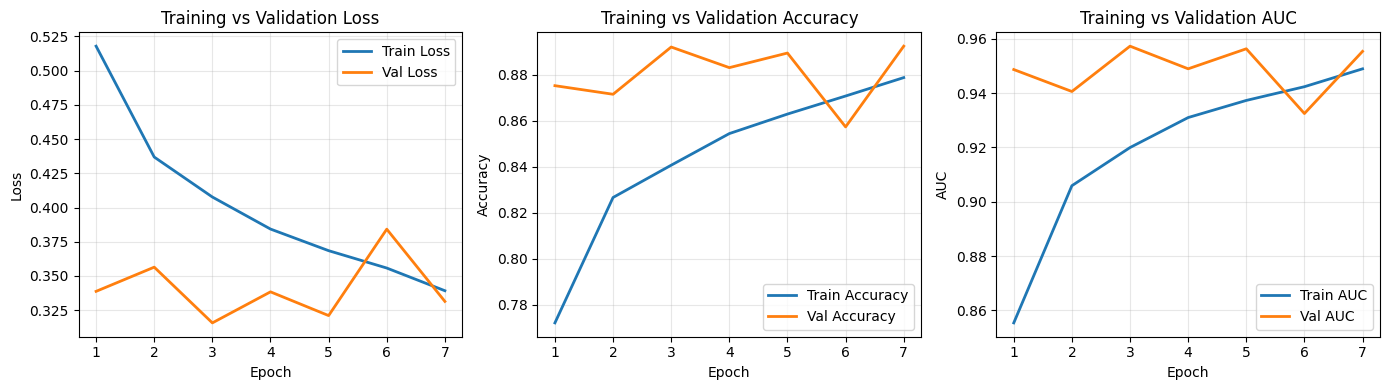

In [77]:
import matplotlib.pyplot as plt
import numpy as np

h = history.history
epochs = np.arange(1, len(h["loss"]) + 1)

plt.figure(figsize=(14,4))

# 1) Loss curve
plt.subplot(1,3,1)
plt.plot(epochs, h["loss"], label="Train Loss", linewidth=2)
plt.plot(epochs, h["val_loss"], label="Val Loss", linewidth=2)
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=0.3)
plt.legend()

# 2) Accuracy curve
plt.subplot(1,3,2)
plt.plot(epochs, h["accuracy"], label="Train Accuracy", linewidth=2)
plt.plot(epochs, h["val_accuracy"], label="Val Accuracy", linewidth=2)
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(alpha=0.3)
plt.legend()

# 3) AUC curve (if available)
if "auc" in h and "val_auc" in h:
    plt.subplot(1,3,3)
    plt.plot(epochs, h["auc"], label="Train AUC", linewidth=2)
    plt.plot(epochs, h["val_auc"], label="Val AUC", linewidth=2)
    plt.title("Training vs Validation AUC")
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.grid(alpha=0.3)
    plt.legend()

plt.tight_layout()
plt.show()
